In [177]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F


In [156]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [157]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
path = '/content/drive/MyDrive/Colab Notebooks/data'

In [160]:
fns = [os.path.join(path, fn) for fn in os.listdir(path)]
fns_training = list(filter(lambda x: 'data_batch' in x, fns))
data = [unpickle(fn) for fn in fns_training]
fns_test = list(filter(lambda x: 'test_batch' in x, fns))
data_test = [unpickle(fn) for fn in fns_test]

In [172]:
# lets split the data into training, validation and test
X = np.concatenate([data[i][b'data'] for i in range(len(data))], axis=0)
Y = np.concatenate([data[i][b'labels'] for i in range(len(data))], axis=0)
Xtr = torch.tensor(X[0:45000, :], dtype=torch.float32)
Ytr = torch.tensor(Y[0:45000]).to(device)
Xdev = torch.tensor(X[45000:50000, :], dtype=torch.float32)
Ydev = torch.tensor(Y[45000:50000]).to(device)
Xtest = torch.tensor(np.concatenate([data_test[i][b'data'] for i in range(len(data_test))], axis=0))
Ytest = torch.tensor(np.concatenate([data_test[i][b'labels'] for i in range(len(data_test))], axis=0))

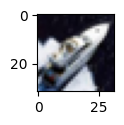

In [162]:
Xtr_conv = Xtr.view(45000, 3, 32, 32)
Xdev_conv = Xdev.view(5000, 3, 32, 32)
Xtest_conv = Xtest.view(10000, 3, 32, 32)
img = (Xtr_conv)[0].numpy().astype(int)
img = np.rollaxis(img, 0, 3)
plt.figure(figsize=(1,1))
plt.imshow(img)

In [203]:
# lets normalize and center the data
Xtr_mean = 1/255.0*Xtr.mean()
Xtr = (Xtr/255.0 - Xtr_mean).to(device)
Xdev = (Xdev/255.0 - Xtr_mean).to(device)
Xtr_conv = (Xtr_conv/255.0 - Xtr_mean).to(device)
Xdev_conv = (Xdev_conv/255.0 - Xtr_mean).to(device)

In [233]:
class NeuralNetwork(nn.Module):
        def __init__(self):
                super().__init__()
                self.mlp = nn.Sequential(
                        nn.Linear(3072, 200), nn.ReLU(),
                        nn.Linear(200, 100), nn.ReLU(),
                        nn.Linear(100, 10)
                )

        def forward(self, x):
                logits = self.mlp(x)
                return logits

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.fc1 = nn.Linear(10 * 8 * 8, 100)
        self.out = nn.Linear(100, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return self.out(x)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 10, 5,padding=2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, 3,padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
          nn.Conv2d(20, 30, 3,padding=1),
          nn.BatchNorm2d(30),
          nn.ReLU(),
          nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(30 * 8 * 8, 100)
        self.out = nn.Linear(100, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return self.out(x)

In [234]:
model = NeuralNetwork().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_conv = CNN().to(device)
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-3)

In [235]:
max_steps = 20000
lossi = [] 
batch_size = 32

In [236]:
for i in range(max_steps):
    #mini batch
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,))
    # Xb, Yb = Xtr[ixs], Ytr[ixs]
    Xb, Yb = Xtr_conv[ixs], Ytr[ixs]
    #forward pass
    logits = model_conv(Xb)
    # logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    #backward pass
    optimizer.zero_grad()  
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

    if i % 1000 == 0:
        print(f"{i}/{max_steps}: {loss.item()}")



0/20000: 2.3484694957733154
1000/20000: 1.1786330938339233
2000/20000: 0.5843284130096436
3000/20000: 0.8487300276756287
4000/20000: 0.8708662986755371
5000/20000: 0.6521649956703186
6000/20000: 0.5079905390739441
7000/20000: 0.5099962949752808
8000/20000: 0.3807986080646515
9000/20000: 0.7037354707717896
10000/20000: 0.6156744360923767
11000/20000: 0.7162589430809021
12000/20000: 0.5195321440696716
13000/20000: 0.5592524409294128
14000/20000: 0.15328006446361542
15000/20000: 0.10496000200510025
16000/20000: 0.2635926306247711
17000/20000: 0.1977180540561676
18000/20000: 0.2806245684623718
19000/20000: 0.16437876224517822


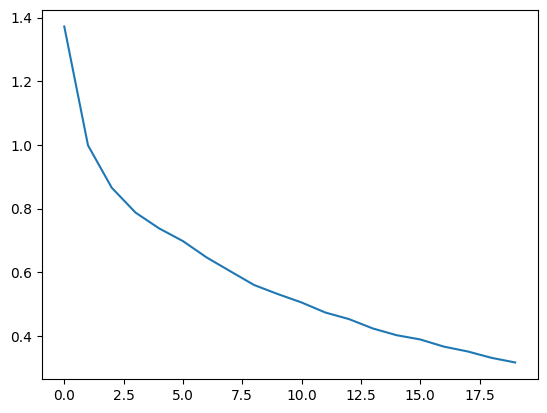

In [237]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [238]:
logits = model_conv(Xdev_conv)
loss_dev = F.cross_entropy(logits, Ydev)
print(f"Training Loss = {loss}, Dev Loss = {loss_dev}")
probs = F.softmax(logits, dim=1)
ypred = torch.multinomial(probs, num_samples=1).view(-1)
sum(ypred == Ydev).item()/len(Ydev)


Training Loss = 0.22633714973926544, Dev Loss = 1.0214664936065674


0.6848